# Multiple Flybys

One question you might have is whether or not you need to consider the importance of running multiple flybys successively (one after another) or concurrently. In this notebook we will show that for most planetary systems, there is not statistical difference between successive flybys and concurrent flybys.

We'll begin by importing the packages we'll need. We're going to make use of the heartbeat functionality in `REBOUND` so be sure to read up on the documentation for that [here](https://rebound.readthedocs.io/en/latest/ipython_examples/Cheartbeat/).

In [1]:
import rebound
import airball
import airball.units as u
from airball.tools import moving_median as mm

import ctypes
import numpy as np
import joblib

import seaborn as sns
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pi = np.pi
twopi = 2.*np.pi

Make sure to simlink the `REBOUND` header file and the `REBOUND` library object file before compiling and linking this C function. This heartbeat function uses the `extras` property of the `REBOUND` simulation to store a pointer to an array of doubles. During the setup in Python we will allocate the memory for the array. We're using a heartbeat function to numerically measure the perihelion of the flyby stars for comparison with the expected value.

In [2]:
%%writefile multiple_flyby_heartbeat.c
#include "rebound.h"

void heartbeat(struct reb_simulation* sim_pointer){
    double* q = (double*)(sim_pointer->extras);
    struct reb_particle* star0 = reb_simulation_particle_by_hash(sim_pointer, reb_hash("flybystar0"));
    if (star0 != NULL) {
        struct reb_orbit orbit = reb_orbit_from_particle(sim_pointer->G, sim_pointer->particles[0], *star0);
        double newd0 = orbit.d;
        if (newd0 < q[0]) { q[0] = newd0; }
    }
    struct reb_particle* star1 = reb_simulation_particle_by_hash(sim_pointer, reb_hash("flybystar1"));
    if (star1 != NULL) {
        struct reb_orbit orbit = reb_orbit_from_particle(sim_pointer->G, sim_pointer->particles[0], *star1);
        double newd1 = orbit.d;
        if (newd1 < q[1]) { q[1] = newd1; }
    }
}

Overwriting multiple_flyby_heartbeat.c


In [3]:
!gcc -c -O3 -fPIC multiple_flyby_heartbeat.c -o multiple_flyby_heartbeat.o

In [4]:
!gcc -L. -shared multiple_flyby_heartbeat.o -o multiple_flyby_heartbeat.so -lrebound

# Setup

Set up the initial `REBOUND` simulation to be the Sun and Neptune. Use IAS15, allocate memory for storing the perihelion of the flyby stars, and connect the C-heartbeat function that we just made.

In [5]:
global NDIM
NDIM = 2 # Number of elements in the array
def setup(hb=True):
    sim = rebound.Simulation()
    sim.rand_seed = 0
    sim.add(m=1)
    sim.add(m=5e-5, a=30, e=0.01)
    sim.integrator = 'ias15'
    sim.ri_ias15.adaptive_mode = 2
    sim.move_to_com()
    if hb:
        extras = (ctypes.c_double * NDIM)(*[np.inf]*NDIM) # Storage for q_stars, a doubles pointer.
        sim.extras = ctypes.cast(extras, ctypes.c_void_p) # Set extras to be the pointer to the array
        clibheartbeat = ctypes.cdll.LoadLibrary("multiple_flyby_heartbeat.so")
        sim.heartbeat = clibheartbeat.heartbeat
    return sim

Set up an extremely dense open cluster environment and generate some random stars. We'll also visualize the overlapping timelines of a random subset of the concurrent flybys.

In [6]:
nruns = 3000
nflybys = 2

oc = airball.OpenCluster(stellar_density=1e5)
try:
    stars = airball.Stars('examples_data/multiple-flybys/stars.stars')
    times = np.load('examples_data/multiple-flybys/times.npy') << oc.units.time
    if times.shape != (nruns, nflybys): raise RuntimeError("Is this the data you intended to use?")
    print("Using existing data.")
except:
    stars = oc.random_stars(size=(nruns, nflybys))
    times = oc.cumulative_encounter_times(size=(nruns, nflybys))
    stars.save('examples_data/multiple-flybys/stars.stars')
    np.save('examples_data/multiple-flybys/times.npy', times.value)
    print("Saved new data.")

Using existing data.


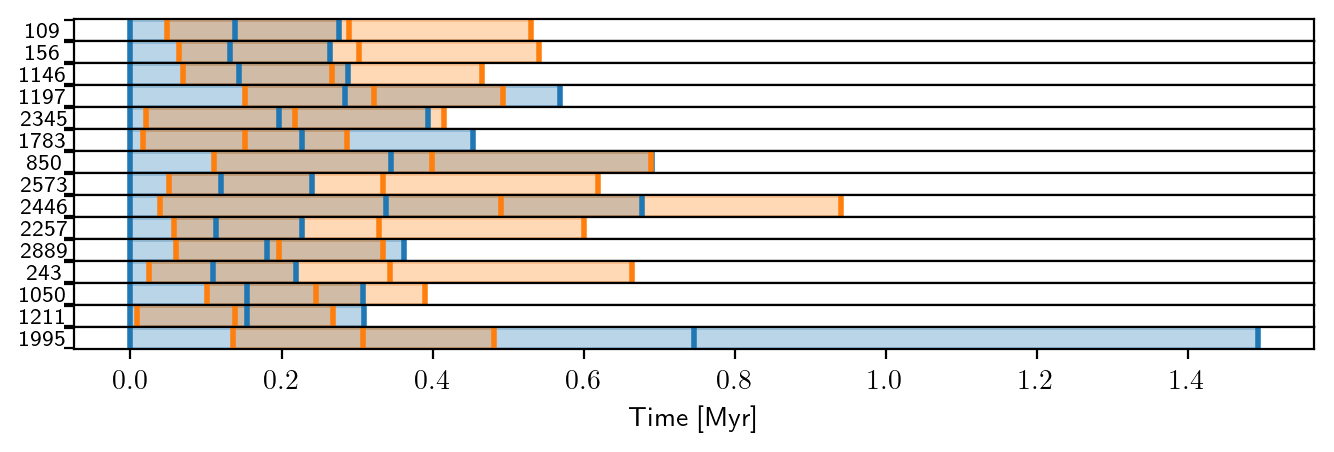

Open Cluster
------------------------------------------
Stellar Density:            1e+05 stars / pc3 
Velocity Scale:                 1 km / s 
Mass Range:              0.08 - 100 solMass
Median Mass:               0.2319 solMass 
Max Impact Param:            1000 AU 
Encounter Rate:             17.89 stars / Myr 
------------------------------------------


In [7]:
nruns_subset = min(15,nruns)
subset = np.random.choice(np.arange(nruns), size=nruns_subset, replace=False)

fig,ax = plt.subplots(nruns_subset,1, figsize=(8,nruns_subset/7), sharex=True)
for k,n in enumerate(subset):
    tperis = ((1e5*u.au)/stars[n].v).to(u.Myr).value
    start = times[n].to(u.Myr).value
    span = np.array([start, start + tperis, start + 2*tperis])
    for i in range(stars[n].N):
        for j in range(3): ax[k].axvline(span[j,i], c=f'C{i}', lw=2)
        ax[k].fill_betweenx([0,1], [span[0,i], span[0,i]], [span[2,i], span[2,i]], color=f'C{i}', alpha=0.3)
        ax[k].set(yticklabels=[])
        ax[k].set_ylabel(f'{n}', rotation=0, y=0, fontsize=8)
ax[-1].set_xlabel('Time [Myr]')
plt.subplots_adjust(hspace=0.0)
plt.show()
oc.stats()

During concurrent flybys, the first star will alter the initially expected location of the Sun, meaning that the expected perihelion of the second flyby star will differ from the actual perihelion. Therefore, we need to carefully measure the perihelia of the stars. We also want to know which of the two stars came closer to the Sun so we can determine which had a larger effect on Neptune.

We'll be running an ensemble of simulations in parallel which may cause the simulations to loose access to their C-pointers when they're being returned by `joblib`. So we'll make sure that we capture the perihelia calculated by our C-heartbeat function before `joblib` returns the simulations.

In [8]:
def run_successive(star):
    sim = setup()
    airball.successive_flybys(sim, star)
    q = np.array((ctypes.c_double * NDIM).from_address(sim.extras))
    return sim, q
    
def run_concurrent(star, time):
    sim = setup()
    airball.concurrent_flybys(sim, star, time)
    q = np.array((ctypes.c_double * NDIM).from_address(sim.extras))
    return sim, q

Run the simulations and process the data for plotting. Separate the simulations from the perihelia results. Takes about 10 minutes on an M2 Pro Macbook Pro.

In [9]:
try:
    ss_sims = rebound.Simulationarchive('examples_data/multiple-flybys/successive-sims.sims')
    cc_sims = rebound.Simulationarchive('examples_data/multiple-flybys/concurrent-sims.sims')
    ss_q = np.load('examples_data/multiple-flybys/successive-perihelia.npy')
    cc_q = np.load('examples_data/multiple-flybys/concurrent-perihelia.npy')
    print("Using existing data.")
except:
    successive_res = joblib.Parallel(n_jobs=-1)(joblib.delayed(run_successive)(stars[n]) for n in range(nruns));
    concurrent_res = joblib.Parallel(n_jobs=-1)(joblib.delayed(run_concurrent)(stars[n], times[n]) for n in range(nruns));
    
    ss_sims, cc_sims = [], []
    ss_q, cc_q = np.zeros((nruns, nflybys)), np.zeros((nruns, nflybys))
    for i,(ss,cc) in enumerate(zip(successive_res, concurrent_res)):
        ss_sims.append(ss[0])
        cc_sims.append(cc[0])
        ss_q[i], cc_q[i] = ss[1], cc[1]
    
    airball.tools.save_as_simulationarchive('examples_data/multiple-flybys/successive-sims.sims', ss_sims)
    airball.tools.save_as_simulationarchive('examples_data/multiple-flybys/concurrent-sims.sims', cc_sims)
    np.save('examples_data/multiple-flybys/successive-perihelia.npy', ss_q)
    np.save('examples_data/multiple-flybys/concurrent-perihelia.npy', cc_q)
    print("Saved new data.")

Using existing data.


Compute the relative change in semi-major axis of Neptune (a direct proxy for the change in energy since $E = -GMm/2a$ for a binary system).

In [10]:
sim = setup(hb=False)
a0 = sim.particles[1].a
ss_da, cc_da = np.zeros(nruns), np.zeros(nruns)
for i in range(nruns):
    ss_da[i] = np.abs((ss_sims[i].particles[1].a - a0)/a0)
    cc_da[i] = np.abs((cc_sims[i].particles[1].a - a0)/a0)

Calculate the analytical estimate for the relative change in the semi-major axis of Neptune for a single flyby of a median star in the system. Also extract the average number of integration steps taken in each simulation to compute the average numerical floating point floor available.

In [11]:
z = airball.Stars(m=np.median(stars.m), v=np.median(stars.v), b=np.logspace(0, 4, nruns))
qs = z.q(sim)
ada = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(airball.relative_energy_change)(sim, z[i], averaged=True) for i in range(nruns)))
nsteps = np.mean([[ss.steps_done, cc.steps_done] for ss,cc in zip(ss_sims, cc_sims)])

Finally, extract the perihelia of the closer of the two flybys for each simulation. This is because the change in energy depends exponentially on the perihelia of the flyby star, so the closest flybys will have the largest effect. This means that even with multiple flybys, only the closest will have the largest effect. Therefore, if we plot the total relative change in energy from all the flybys against the closest approach of the most impactful stellar flyby, the result should follow very closely to the theoretical change for a single flyby coming to that distance.

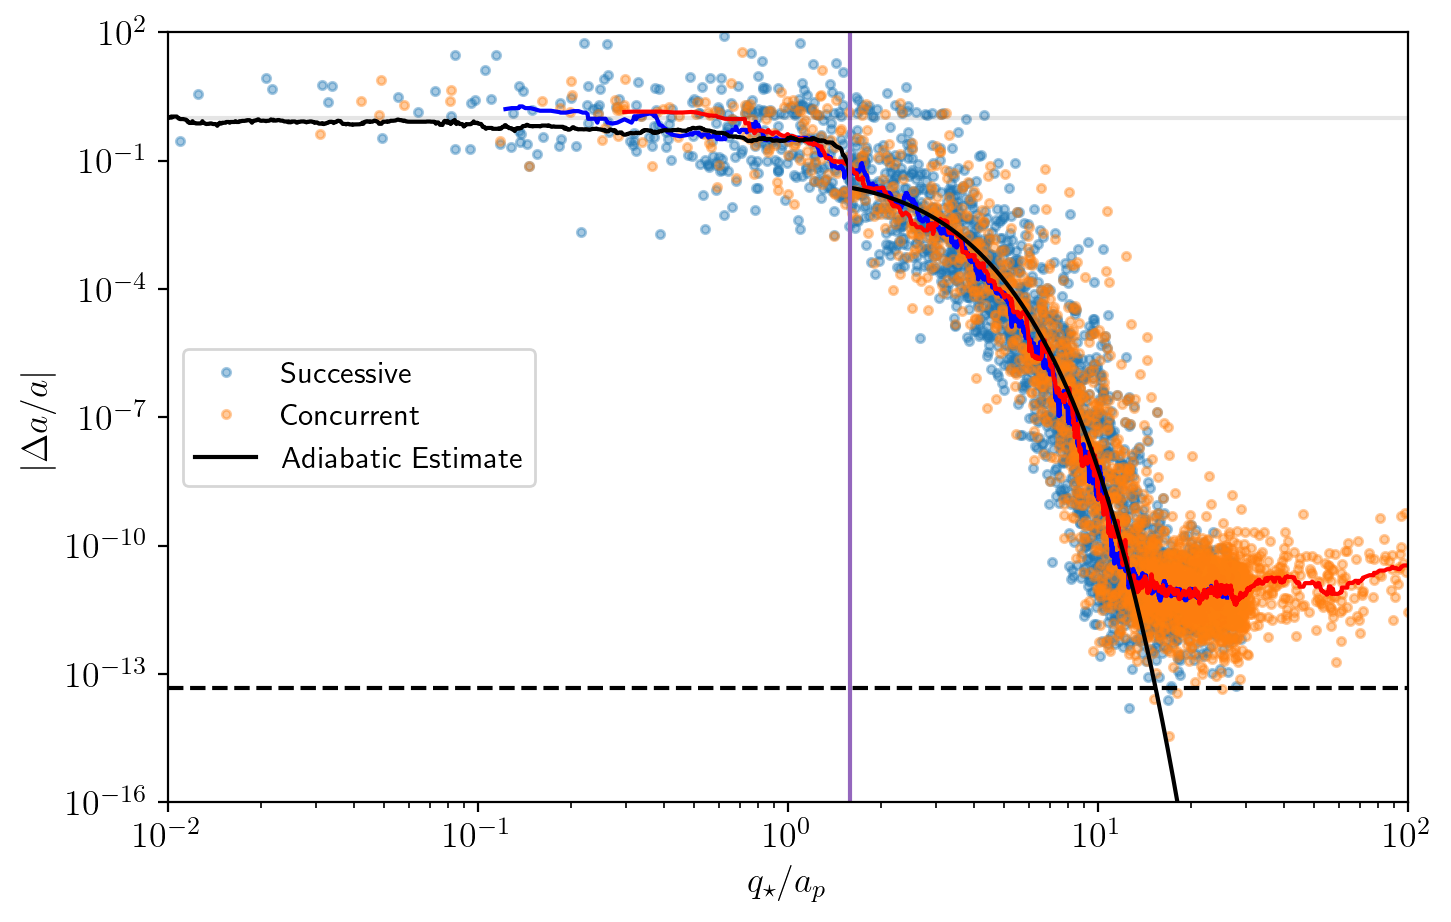

In [12]:
ss_qmin, cc_qmin = np.min(ss_q, axis=1), np.min(cc_q, axis=1)
ss_inds, cc_inds = np.argsort(ss_qmin), np.argsort(cc_qmin)
n = 50

plt.rcParams.update({'font.size': 13})
fig,ax = plt.subplots(1,1, figsize=(8,5), sharex=True, sharey=False)
ax.loglog(ss_qmin[ss_inds]/a0, ss_da[ss_inds], '.', alpha=0.4, label='Successive')
ax.loglog(cc_qmin[cc_inds]/a0, cc_da[cc_inds], '.', alpha=0.4, label='Concurrent')
ax.loglog(mm(ss_qmin[ss_inds]/a0, n), mm(ss_da[ss_inds], n), 'b-')
ax.loglog(mm(cc_qmin[cc_inds]/a0, n), mm(cc_da[cc_inds], n), 'r-')
ax.loglog(mm(qs/a0,n), mm(np.abs(ada),n), 'k-', label='Adiabatic Estimate')
ax.axvline(2**(2/3), c='C4')
ax.axhline(np.sqrt(nsteps) * 2**-53, c='k', ls='--')
ax.axhline(1, c='k', ls='-', alpha=0.1)
ax.set_ylim([1e-16, 1e2])
ax.set_xlim([1e-2, 1e2])
ax.set_ylabel(r'$|\Delta a/a|$')
ax.set_xlabel(r'$q_\star/a_p$')
ax.legend(prop={'size': 11})
plt.show()

While the results of successive flybys are not identical to the concurrent flybys, statistically, they are very similar. This figure shows that the median change in energy from both successive (blue line) and concurrent (red line) flybys are remarkably similar and follow very closely to the theoretical adiabatic estimate of a single flyby star (solid black line). Deviations from the theoretical estimate only really occur in the numerical floor limit (dashed black line) and when the theoretical assumption that $q_\mathrm{star} \gg a_\mathrm{planet}$ begins to break down (purple line). The non-adiabatic regime is also where Neptune is consistenly ejected from the Sun (solid grey line).

The reason why the results of concurrent flybys may be unintuitive compared to successive flybys, but are not statistically different is because of how the interaction between the Sun flyby stars alter expectations. In general, the interactions from the first flyby causes the perihelion of the second flyby to be larger than originally expected. This can be seen in the figure above, but can more easily be seen in the histrograms below.

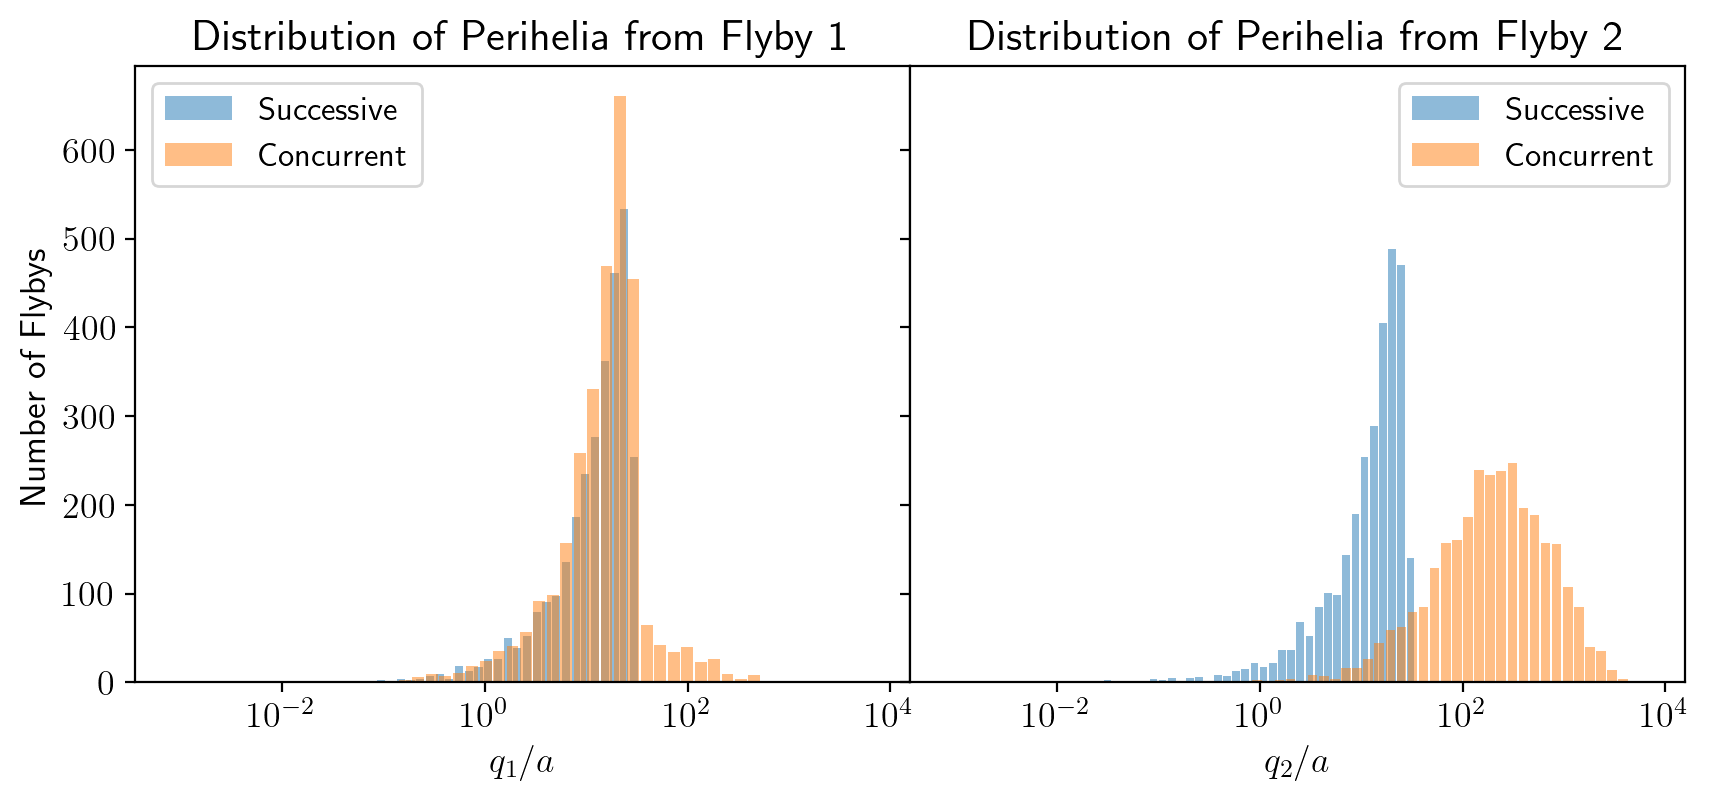

In [13]:
a0,v0 = setup().particles[1].a, (np.linalg.norm(setup().particles[1].v) * u.au/u.yr2pi).to(u.km/u.s).value
fig,ax = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
for i,q in enumerate([ss_q[:,0], ss_q[:,1], cc_q[:,0], cc_q[:,1]]):
    x, y, w = airball.tools.hist10(q/a0, bins=50, wfac=0.75)
    ax[i%2].bar(x, y, width=w, alpha=0.5, label='Successive' if i < 2 else 'Concurrent')
    ax[i%2].set_title(f'Distribution of Perihelia from Flyby {i%2 + 1}')
    ax[i%2].set_xlabel(rf'$q_{{{i%2 + 1}}}/a$')
    ax[i%2].legend(prop={'size': 12})
ax[0].set_ylabel(r'Number of Flybys')
ax[0].set_xscale('log')
plt.subplots_adjust(wspace=0.0)
plt.show()

There is also a trend that the slower moving stars are the ones that cause the perihelia to be adjusted outward. In the case of concurrent flybys, the slower moving star will tend to reach perihelion later, even if its approach began earlier. This means that the faster star will interact with the Sun first causing the perihelion of the second star to be lifted compared to the expected value. This is seen as an negative correlation between perihelia and velocity, while gravitational focusing shows a positive correlation causing slower moving stars to have smaller perihelia.

In the figure below, the vertical red line divides close (left) and wide (right) encounters, the purple line divides non-adiabatic (left) and adiabatic (right), and the green line divides hyperbolic (top) and near-parabolic (bottom). Most of the stars in an open cluster are adiabatic flybys with a few being close, near-parabolic flybys. 

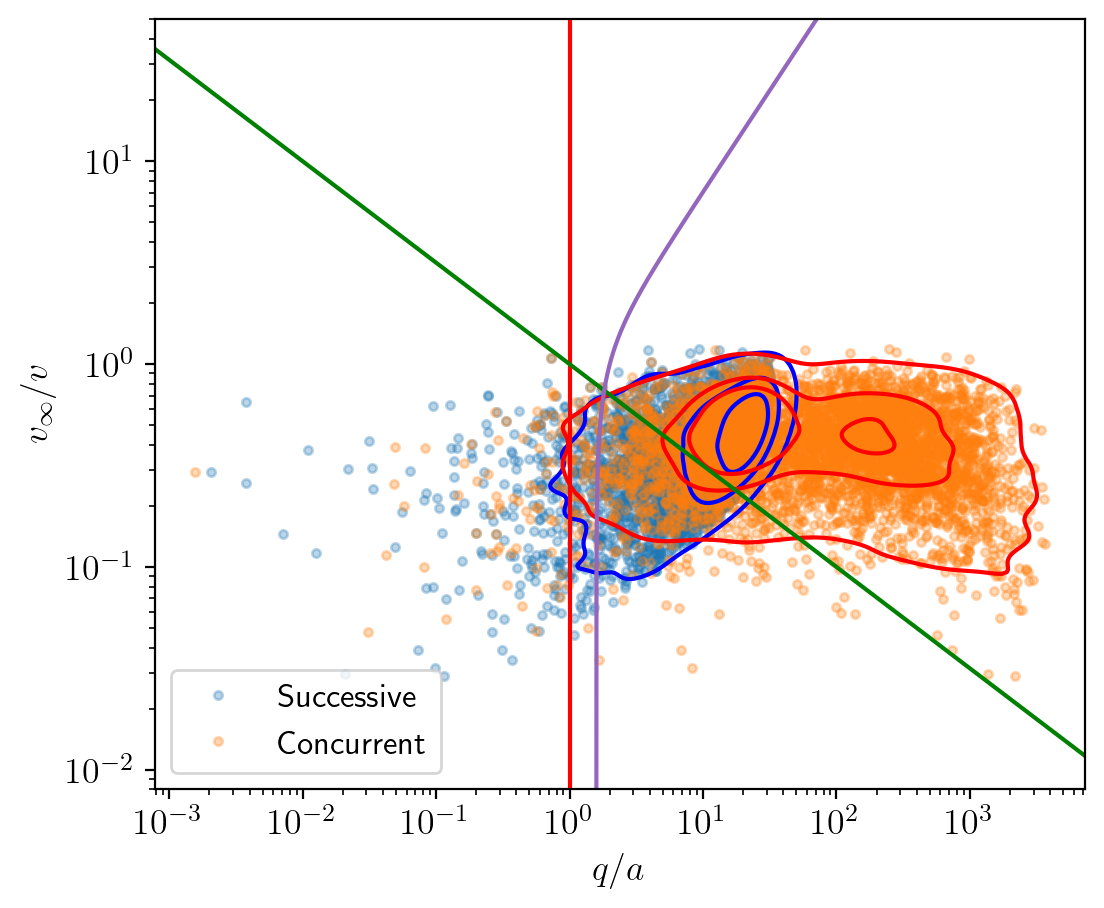

In [14]:
v0 = (np.linalg.norm(sim.particles[1].v) * u.au/u.yr2pi).to(u.km/u.s)
plt.rcParams.update({'font.size': 13})
fig,ax = plt.subplots(1,1, figsize=(6,5), sharex=False, sharey=False)
xmin = min(1e-2, np.min(ss_q/a0)*0.5, np.min(cc_q/a0)*0.5)
xmax = max(np.max(ss_q/a0)*2.0, np.max(cc_q/a0)*2.0, 50)
qa = np.logspace(np.log10(xmin), np.log10(xmax), 1_000_000)
V = (stars.v/v0)
ax.loglog(ss_q.flatten()/a0, V.flatten(), 'C0.', alpha=0.3, label=f'Successive')
ax.loglog(cc_q.flatten()/a0, V.flatten(), 'C1.', alpha=0.3, label=f'Concurrent')
sns.kdeplot(x=ss_q.flatten()/a0, y=V.flatten(), color='b', log_scale=True, levels=4)
sns.kdeplot(x=cc_q.flatten()/a0, y=V.flatten(), color='r', log_scale=True, levels=4)
ax.axvline(1, c='r')
ax.plot(qa, 1./np.sqrt(qa), 'g-')
ax.plot(qa[qa >= 2**(2/3)], np.sqrt(2.)*(qa[qa >= 2**(2/3)])*np.sqrt(0.25-(qa[qa >= 2**(2/3)])**(-3)), 'C4-')
ax.set_xlabel(r'$q/a$')
ax.set_ylabel(r'$v_\infty/v$')
ax.legend(prop={'size': 12})
ax.set_xlim([xmin, xmax])
ax.set_ylim([min(8e-3, np.min(V)*0.5), max(np.min(V)*2, 50)])
plt.show()